# <span style="color:blue">Aprendizaje Automático</span>

## Integrantes:
- Daniel Roman Ramirez
- Obed Ríos-Ruiz

# Contexto de los datos

Los datos con los que se cuenta es el conjunto de salidas de múltiples sensores asociadas a un enfriador de un horno de cemento para una ventana temporal dada. El nivel de detalle de la información es entregado con una frecuencia temporal de $1$ minuto para $31$ variables numéricas del proceso.

## 1. Recopilación de datos
A continuación se comenta del proceso de recopilación de datos para la posible construcción de un proceso productivo que consuma esta fuente de información

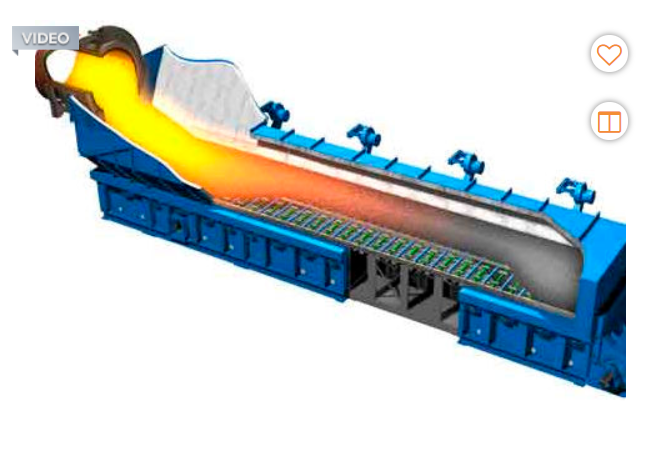

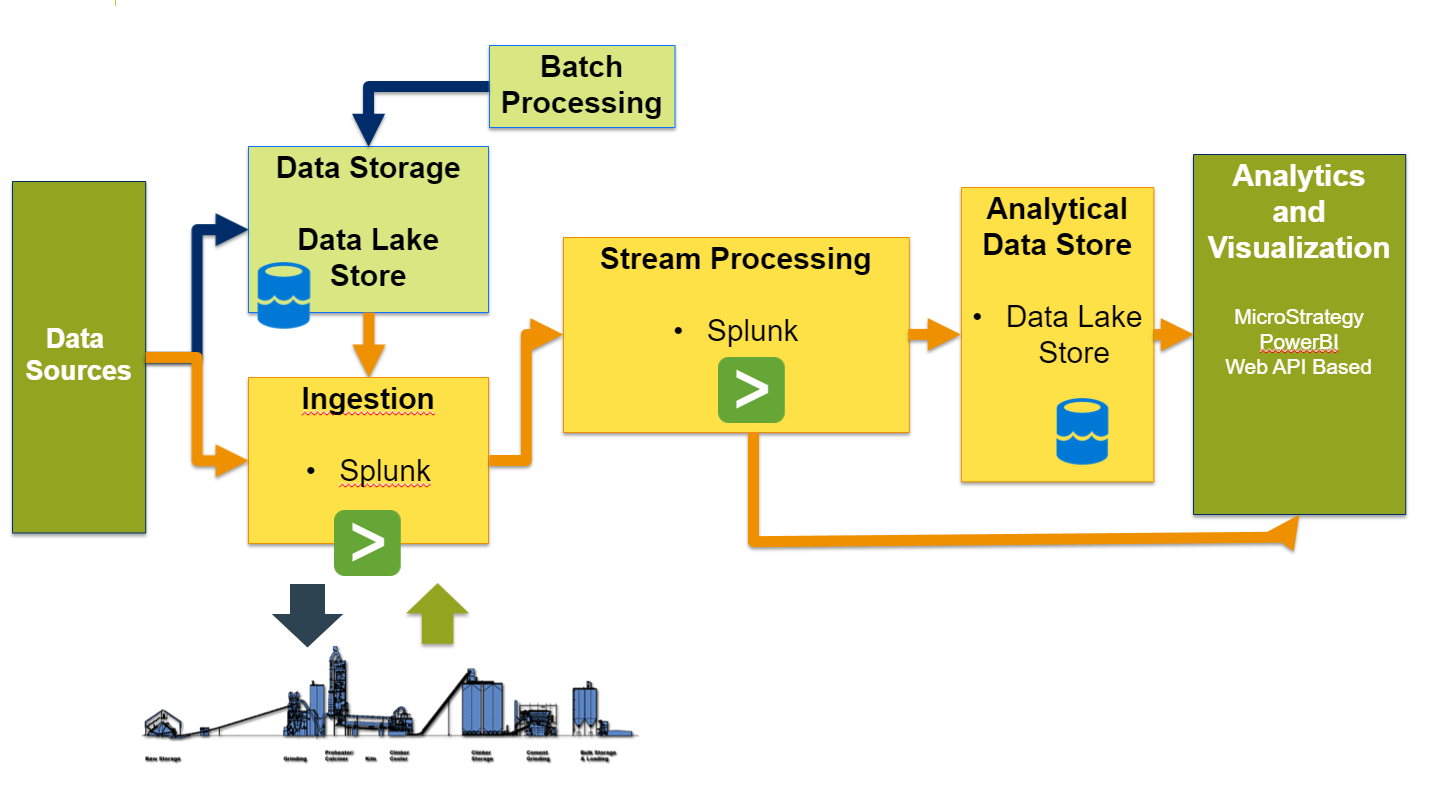

En el diagrama de arquitectura previo se tiene un flujo de datos en el cual las plantas de producción cementera reportan, por medio de servidores y puertos, sus medidas a un punto de conexión [Splunk](https://www.splunk.com/), el cual es un producto que permite capturar, indexar y procesar datos en tiempo real.

### 1.1. Extracción de datos

Para efectos de testeo se entrega una muestra de datos de uno de los componentes de una de las plantas monitoreadas, en particular el **Enfriador_RC**, el cual regula la temperatura del clinker, materia prima para la producción de cemento, a la salida de un horno. Dicha muestra es entregada en formato de archivo plano con extensión <tt>csv</tt>; no obstante, en caso de construirse un modelo que responda a la variable de control, éste podría, sin inconvenientes, incluirse en el flujo de transformación de datos de <tt>Splunk</tt>.

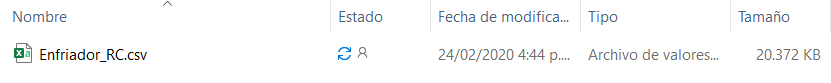

### 1.2. Resumen datos

Para la muestra a disposición, la cual contiene un intervalo temporal de $29$ días, desde el $12/11/2019$ al $11/12/2019$ con una frecuencia minuto a minuto se tiene

<table>
  <tr>
    <th>Descripción general</th>
    <th>Nombre base</th>
    <th>Formato</th>
    <th>Cantidad de columnas</th>
    <th>Cantidad de filas</th>
    <th>Cantidad de variables categorías</th>
    <th>Cantidad de variables numéricas</th>
    <th>Cantidad de variables temporales</th>    
  </tr>
  <tr>
    <td>Información enfriador</td>
    <td>Enfriador_RC</td>
    <td>csv</td>
    <td>33</td>
    <td>43.160</td>
    <td>0</td>
    <td>32</td>
    <td>1</td>    
  </tr>
</table>

### 1.3. Metadata

| Campo           	| Descripción                                                                   	|
|-----------------	|-------------------------------------------------------------------------------	|
| Alimentacion    	| Alimentacion Total (Tn/Hora Harina)                                           	|
| CFN_x           	| Caudal Fan Normal (M3/H) _X Marcacion                                         	|
| CFT             	| Caudal Fan Total                                                              	|
| Fcapa           	| Relacion Presion De Capa Sobre El Objetivo De Presion De Capa                 	|
| Iparilla1       	| Corriente Parrilla 1                                                          	|
| Iparilla2       	| Corriente Parrilla 2                                                          	|
| Iparrilla_obj   	| Corriente Parrilla Obj -- Parámetro                                           	|
| NOx             	| Medida Oxido Nitroso (Parte Por Millon)                                       	|
| O2              	| Medida Oxigeno En El Horno                                                    	|
| PFN300          	| Presion Ventilador 300                                                        	|
| PFN305          	| Presion Ventilador 305                                                        	|
| Pcapa           	| Presion Capa (Mb)                                                             	|
| Pcapa_obj       	| Presion Capa (Mb) Objetivo --- Parámetro                                      	|
| Pcapota         	| Presion Capota                                                                	|
| RACK            	| Relacion Aire-Clinker (M3/Kg Clinker) --- Parámetro                           	|
| TaireSec1       	| Temperatura Aire Secundario 1                                                 	|
| TaireSec2       	| Temperatura Aire Secundario 2                                                 	|
| TaireSec2_obj   	| Temperatura Aire Secundario 2 Objetivo -- Parámetro                           	|
| TinFilter       	| Temperarura Wentreadndo Al Filtro                                             	|
| Tparrilla1      	| Temperatura Parrilla 1                                                        	|
| Tparrilla2      	| Temperatura Parrilla 2                                                        	|
| TsalidaE        	| Temp Salida Enfriador                                                         	|
| Vtiro           	| Velocidad Ventilador Tiro (% Resoecto A Vel Max Ventilador) / Ppal Horno      	|
| VTiroExitCooler 	| Velocidad Ventilador Tiro (% Resoecto A Vel Max Ventilador) /Salida Enfriador 	|
| Vhorno          	| Velocidad De Giro Del Horno (Rpm)                                             	|
| Vparrilla       	| Velocidad Parrilla 1/2 (% Respecto A Vel Maxima)                              	|

## 2. Características

### 2.1. Caso de negocio

Al equipo de planta le interesa obtener estimaciones futuras de la temperatura del enfriador $TaireSec2$ a partir de las medidas obtenidas de los sensores anexos al sistema. Se expone una restricción sobre la salida y es que debe tener significado fisico para el sistema, de forma que se pueda tomar como variable de control

## 3. Aprendizaje Supervisado

### 3.1. Data Cleaning

In [1]:
from IPython.display import display, HTML

In [2]:
%matplotlib inline

In [3]:
import os

from pathlib import Path

In [4]:
import time
import json
import sqlite3

import logging
import logging.config
from logging.handlers import RotatingFileHandler

import pandas as pd
import datetime as dt
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

from sklearn import  preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.utils.validation import column_or_1d

pd.options.display.max_columns = None

C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
def setup_logging(default_path='logging_config.json',
                  default_level=logging.INFO, env_key='LOG_CFG'):
    """
    Setup logging configuration
    """
    
    path = Path(default_path)
    value = os.getenv(env_key, None)
    if value:
        print(f"Using configuration from environment variable {env_key}")
        path = value
    if path.exists():
        with open(path, 'r') as f:
            config = json.load(f)
        print(f"Using logging configuration from {path}")
        logging.config.dictConfig(config)
    else:
        print(f"Using basic logging configuration")
        logging.basicConfig(level=default_level)

In [6]:
def carga_model(base_path, path_savs, sav_name):
    ext = 'sav'
    f_name = f"{sav_name}.{ext}"
    
    f_path = os.path.join(base_path, path_savs, f_name)
    
    samples = {'path' : f_path}
    
    try:
        if not os.path.isfile(f_path):
            logger.error(f"File {f_path} does not exist")            
            raise Exception('non-existing file')
            
        loaded_model = joblib.load(f_path)
        samples['model'] = loaded_model
            
    except Exception as e:
        logger.error(f"Falla en base de datos {f_path}: " + str(e))    
       
    return samples

In [7]:
def save_sqlite(base_path, file_path, data, sqlite_name, table_name):
    ext = 'sqlite3'    
    f_name = f'{sqlite_name}.{ext}'
    
    sample_f_path = os.path.join(base_path, file_path, f'{f_name}')
    con  = sqlite3.connect(sample_f_path)
    logger.info(f"Saving results en {sample_f_path}")    
    
    data.to_sql(table_name, con, if_exists = 'append', index = False)
    
    con.close()
    
    return None

In [17]:
def read_sqlite(base_path, file_path, sqlite_name, table_name):
    ext = 'sqlite3'
    f_name = f'{sqlite_name}.{ext}'
                
    sample_f_path = os.path.join(base_path, file_path, f'{f_name}')
    con  = sqlite3.connect(sample_f_path)
    logger.info(f"Reading results en {sample_f_path}") 
                
    sq_str = f"""SELECT
                    * 
                FROM {table_name}"""
                
    sq_resque = pd.read_sql_query(sq_str, con)
    
    return sq_resque

In [8]:
dir_str = r'C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte'
base_path = Path(dir_str)
projekt = '0. Bitacora\Master\CM0891\CM0891'

base_rute = os.path.join(base_path, projekt)

In [9]:
setup_logging(os.path.join(base_path, projekt, "logs/logging_config.json"))
logger = logging.getLogger()
logger.info("Setting up log configuration")

INFO:root:Setting up log configuration


Using basic logging configuration


In [10]:
now_date = dt.datetime.now()

In [11]:
data_source = 'ds3_DIGITAL'

f_file = 'Enfriador_RC'
f_ext = 'csv'

f_path = os.path.join(base_path, projekt, 'data_sources', data_source, 'data', f'{f_file}.{f_ext}')

In [12]:
base_data = pd.read_csv(f_path, sep = ',', encoding = 'UTF-8', decimal = '.')

In [13]:
base_data.dtypes

Alimentacion       float64
CFN300             float64
CFN305             float64
CFN310             float64
CFN315             float64
CFN320             float64
CFN325             float64
CFT                float64
Fcapa              float64
Iparrilla1         float64
Iparrilla2         float64
Iparrilla_obj      float64
NOx                float64
O2                 float64
PFN300             float64
PFN305             float64
Pcapa              float64
Pcapa_obj          float64
Pcapota            float64
RACK               float64
TaireSec1          float64
TaireSec2          float64
TaireSec2_obj      float64
TinFilter          float64
Torque             float64
Tparrila1          float64
Tparrila2          float64
TsalidaE           float64
VTiro              float64
VTiroExitCooler    float64
Vhorno             float64
Vparrilla          float64
_time               object
dtype: object

In [14]:
# Remove first row, which has no data at all
base_data = base_data.iloc[1:]

In [15]:
# Setting time config
base_data['_time'] = pd.to_datetime(base_data['_time'])
base_data['_time'] = base_data['_time'].apply(lambda x: x - x.utcoffset()).apply(lambda x: x.replace(tzinfo=None))
base_data = base_data.set_index('_time', drop = True)

In [16]:
# Data description

desc_base = base_data.describe(include = 'all')
desc_base.loc['dtype'] = base_data.dtypes
desc_base.loc['size'] = len(base_data)
desc_base.loc['% count'] = base_data.isnull().mean()

desc_base.T

count      mean       std          min       25%       50%  \
Alimentacion     40907   111.076    45.414  2.66152e-38   99.6491   134.862   
CFN300           42892   251.435    108.85      5.38382   299.286   299.934   
CFN305           42892   309.365   74.9938       146.21    341.35   349.268   
CFN310           42892   291.018    124.22      41.5253   345.993   355.943   
CFN315           42892   251.724   95.7931      61.9004   281.183   290.698   
CFN320           42892   351.706   130.503      103.643   394.349   401.426   
CFN325           42892    478.02   31.9047      85.6598    473.86   484.368   
CFT              42892   1933.27   526.376      768.915   2146.32   2191.28   
Fcapa            42891  0.790514  0.330178     0.118736  0.764762  0.955637   
Iparrilla1       42892   18.1058   9.52893    -0.591338   16.8671   21.0942   
Iparrilla2       42891   21.3169   11.7409    -0.644709   18.5479   24.5922   
Iparrilla_obj        0       NaN       NaN          NaN       NaN       NaN   
NOx              42892   449.403   440.486            0   8.54701   330.281   
O2               42892   9.86169   6.18723            0     5.485     6.315   
PFN300           42892   45.6277   20.1014     0.913566   49.3524   54.3094   
PFN305           42892   42.5574   17.9204      8.93116   38.2794    51.467   
Pcapa            42891   43.4783   18.1598       6.5305   42.0619     52.56   
Pcapa_obj            0       NaN       NaN          NaN       NaN       NaN   
Pcapota          42891 -0.232507   0.18776     -1.60031 -0.272292 -0.234013   
RACK                 0       NaN       NaN          NaN       NaN       NaN   
TaireSec1        42891   710.946    332.41    -0.104107    744.48   866.218   
TaireSec2        42891   547.874   260.973     -5.17431   539.923   653.128   
TaireSec2_obj        0       NaN       NaN          NaN       NaN       NaN   
TinFilter        42892   256.559   124.264      18.9419   219.061   306.556   
Torque           36728   16.7736   27.5865     -30.8316   16.4343   27.3527   
Tparrila1        42891   60.2728   7.52531      47.5776   57.3187    59.531   
Tparrila2        42891   80.7213   21.0749           50   68.7958   73.6919   
TsalidaE         42891   276.511   151.569      24.7773   188.475   303.824   
VTiro            42892   75.7362   33.8255            0   86.9788    92.995   
VTiroExitCooler  42891   71.8528   16.4242            0   72.4812   79.2775   
Vhorno           36728   1.37645   0.76585    -0.219001  0.668328   1.82399   
Vparrilla        42892   32.8744   15.4472    -0.185337   33.6385   37.4648   

                      75%      max    dtype   size     % count  
Alimentacion      139.836  145.852  float64  43160   0.0522011  
CFN300            300.385  311.628  float64  43160  0.00620945  
CFN305            351.004  454.375  float64  43160  0.00620945  
CFN310            360.573  399.294  float64  43160  0.00620945  
CFN315             302.51  449.193  float64  43160  0.00620945  
CFN320            416.805  500.727  float64  43160  0.00620945  
CFN325            492.494  560.344  float64  43160  0.00620945  
CFT               2217.79  2424.61  float64  43160  0.00620945  
Fcapa            0.997276  1.19667  float64  43160  0.00623262  
Iparrilla1        23.7514  53.8382  float64  43160  0.00620945  
Iparrilla2         29.033  70.7241  float64  43160  0.00623262  
Iparrilla_obj         NaN      NaN  float64  43160           1  
NOx               729.854   2441.7  float64  43160  0.00620945  
O2                  19.36     20.5  float64  43160  0.00620945  
PFN300            56.6025  74.2147  float64  43160  0.00620945  
PFN305            54.2276  66.4657  float64  43160  0.00620945  
Pcapa             54.8502  65.8169  float64  43160  0.00623262  
Pcapa_obj             NaN      NaN  float64  43160           1  
Pcapota         -0.173566  1.76997  float64  43160  0.00623262  
RACK                  NaN      NaN  float64  43160           1  
TaireSec1         914.102  1073.74  float64 

In [17]:
# No functional data - set at 50% null data -  entire columns

to_drop = desc_base.T.reset_index(drop = False).rename(columns = {'index' : 'cols'})
cols_drop = to_drop[to_drop['% count'] >= 0.5].cols.values

In [18]:
# Ef dropping
base_data = base_data.drop(cols_drop, axis = 1)

In [19]:
# Variables set
cols_output = ['TaireSec2']
cols_feat = list(base_data.columns)
cols_feat.remove(*cols_output)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


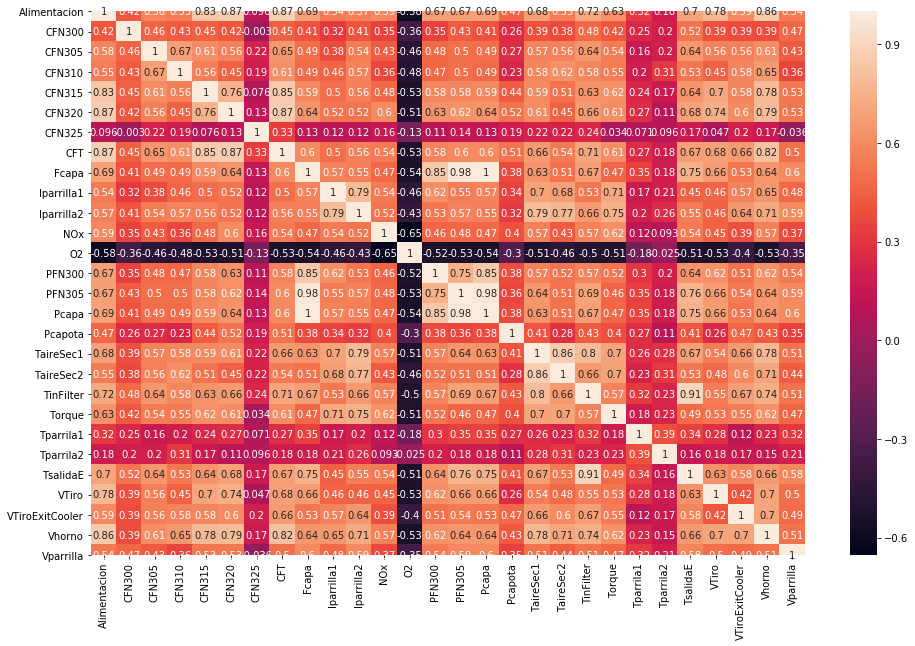

In [20]:
corrMatrix = base_data.corr(method = 'spearman')

plt.subplots(figsize = (16,10))
sn.heatmap(corrMatrix, annot=True)

In [21]:
# Identificación de variables altamente correlacionadas
# Se eliminan aquellas por encima de 0.9

upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

Por definición del sistema $TaireSec1$ es espejo de $TaireSec2$ (variable a predecir), por lo que debería retirarse para no generar redundancia en el sistema de variables. Esta remoción es también justificada por el alto nivel de correlación expuesta en la gráfica anterior

In [22]:
base_data = base_data.drop(to_drop + ['TaireSec1'] , axis = 1)

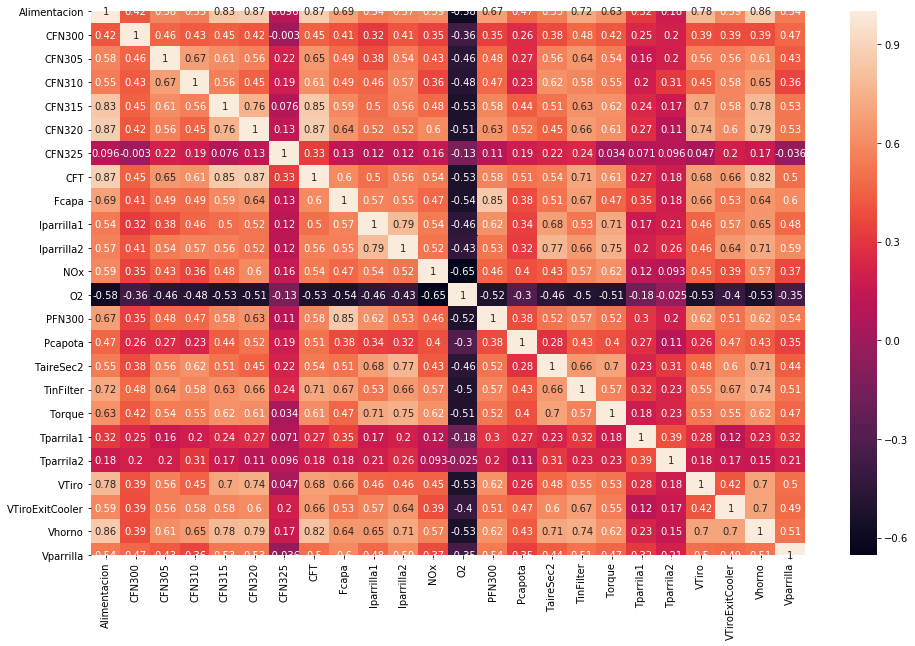

In [23]:
corrMatrix = base_data.corr(method = 'spearman')

plt.subplots(figsize = (16,10))
sn.heatmap(corrMatrix, annot=True)

In [24]:
cols_feat.remove('TaireSec1')
for drop_col in to_drop:
    cols_feat.remove(drop_col)

#### <span style="color:red">Nota</span>

Se laggea la variable de salida en períodos del tiempo pasados. Esto se efectúa porque estamos hablando de una variable de temperatura, que entendemos tiene comportamientos físicos decayentes en el tiempo que la afectan constantemente, así que es natural considerar estos lags.

In [25]:
# Adding previos outputs

lags = 10
for i in range(1, lags + 1):
    base_data['TaireSec2' + f'_{i}'] = base_data['TaireSec2'].shift(i)

#### <span style="color:red">Nota</span>

Se aplica lag sobre la variable de salida, dada la intención de generar predicciones para el período $t+1$ a partir de la información pasada en $t$, $t-1$, $t-2$, ..., $t-10$.

In [26]:
# Shifting for prediction t-1 ==> t
base_data[cols_output] = base_data[cols_output].shift(periods = -1)

#### <span style="color:red">Nota</span>

Se incluyen lags de las variables fisicas para simular el comportamiento físico del sistema en el tiempo, esto habiendo ordenado el conjunto de datos

In [27]:
# Create lagging for columns

lags = 20
for c_feat in cols_feat:
    for i in range(1, lags + 1):
        base_data[c_feat + f'_{i}'] = base_data[c_feat].shift(- 1 * i)

In [28]:
# Create moving average

for c_feat in cols_feat:    
    base_data[c_feat + '_mean'] = (base_data[c_feat + '_1'] +  base_data[c_feat + '_2'] +  base_data[c_feat + '_3'])/3

In [29]:
# No functional data - cells
base_data = base_data.dropna()

In [30]:
x_cols = list(base_data.columns)
x_cols.remove(*cols_output)

#### <span style="color:red">Feature Selection</span>

Para efectos de feature selection aplicamos un *RandomForest* estandarizando la muestra de datos.

Se toman todos los datos

In [31]:
n_estimators = 100

x = ((base_data[x_cols] - base_data[x_cols].mean())/base_data[x_cols].std()).values
y = base_data[cols_output].values[:,-1]

regressor = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)  
regressor.fit(x, y)

fi = pd.DataFrame({'feature': x_cols,
               'importance': regressor.feature_importances_}).\
                sort_values('importance', ascending = False).reset_index(drop = True)

<span style="color:red">**Nota**</span>

Con este resultado identificamos, de acuerdo al coeficiente de Gini, interno al método RandomForest, aquellas variables que mejor explican la salida por medio de la varianza.

Posteriormente las aplicamos en el forward selection method para la selección real de las características

In [32]:
fi.iloc[0:30]

feature    importance
0       TaireSec2_1  9.985637e-01
1       TaireSec2_2  7.893843e-04
2       TaireSec2_3  4.891767e-04
3       TaireSec2_5  1.770594e-05
4       TaireSec2_4  1.655038e-05
5       TaireSec2_6  1.362405e-05
6       TaireSec2_7  1.019898e-05
7       TaireSec2_8  6.835723e-06
8      TaireSec2_10  5.337159e-06
9       TaireSec2_9  5.112247e-06
10  Iparrilla1_mean  4.431067e-06
11     Iparrilla1_4  1.660079e-06
12     Iparrilla1_3  1.495485e-06
13     Iparrilla1_2  1.406218e-06
14        TinFilter  1.353746e-06
15       Iparrilla1  1.320379e-06
16     Iparrilla1_1  1.203957e-06
17     Iparrilla1_5  1.008266e-06
18      CFN305_mean  8.931073e-07
19           CFN305  7.343031e-07
20          Fcapa_9  7.183051e-07
21     Iparrilla1_6  6.957971e-07
22     Vparrilla_15  6.188493e-07
23        Torque_16  5.634617e-07
24     Iparrilla1_7  5.580604e-07
25     Vparrilla_13  5.456291e-07
26      TinFilter_1  5.001722e-07
27    Iparrilla2_17  4.984090e-07
28         Fcapa_10  4.928164e-07
29    Iparrilla2_15  4.913096e-07

In [33]:
fi_path = os.path.join(base_path, projekt, 'data_sources', data_source, 'res', 'importance_ff.csv')
fi.to_csv(fi_path, sep = '|', encoding = 'UTF-8')

<span style="color:red">**Nota**</span>

Se usa el orden entregado previamente por el análisis de importancia dado por el **RandomForestRegressor** para evaluar la salida en **r2** del modelo dadas las respectivas variables, se usa una vez más un randomforest

<span style="color:red">**Forward selection method for feature engineering**</span>
> Using r2 metric for model evaluation

In [34]:
all_cols_rel = [x[0] for x in fi.iloc[0:50].values]

comps = []
iters = {}
cont = 0

for to_int in all_cols_rel:
    comps.append(to_int)
    
    # Splitting training and testing dfs
    X_train, X_test, Y_train, Y_test = train_test_split(base_data[comps], base_data[cols_output], 
                                                    test_size = 0.2, shuffle=False)
    
    Y_train = column_or_1d(np.ravel(Y_train), warn = True)
    
    pipeline = Pipeline([('scaler', StandardScaler()), 
                         ('random',  RandomForestRegressor(n_estimators = 10, random_state = 0))])
    
    pipeline.fit(X_train, Y_train)    
    
    Y_pred = pipeline[1].predict(pipeline[0].transform(X_test))
    
    res_r2 = r2_score(Y_test, Y_pred)
    
    iters[cont] = {'fields' : comps, 'r2' : res_r2}
    
    cont += 1

<span style="color:red">**Nota**</span>

- Nótese como desde este punto la medida de evaluación **r2** resulta relativamente favorable
- Adicionalmente, la partición del conjunto de entrenamiento y validación no se hace aleatoria debido a que queremos conservar el orden temporal de las variables, de modo que tengamos una mayor probabilidad de acertar a los períodos posteriores (de validación).

Text(0, 0.5, 'r2')

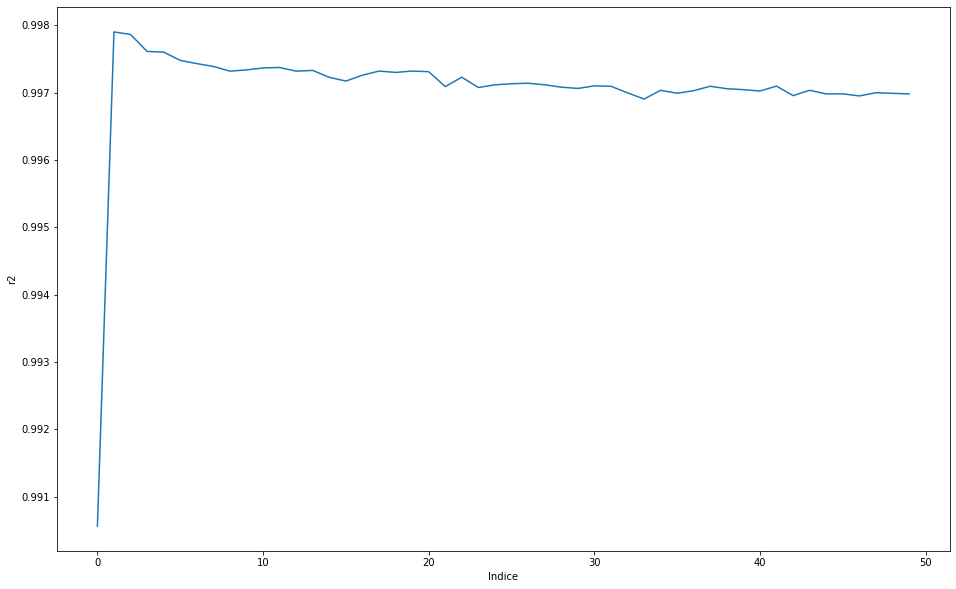

In [35]:
fig, ax = plt.subplots(figsize = (16,10))
plt.plot(list(iters.keys()), [x['r2'] for _, x in iters.items()])
plt.xlabel('Indice')
plt.ylabel('r2')

Se selecciona el conjunto de características que maximizan la curva para el conjunto de entrenamiento

In [36]:
r2_values = [x['r2'] for _, x in iters.items()]
posmax_r2 = r2_values.index(max(r2_values))

cols_rel = iters[posmax_r2]['fields']

In [37]:
cols_rel

['TaireSec2_1',
 'TaireSec2_2',
 'TaireSec2_3',
 'TaireSec2_5',
 'TaireSec2_4',
 'TaireSec2_6',
 'TaireSec2_7',
 'TaireSec2_8',
 'TaireSec2_10',
 'TaireSec2_9',
 'Iparrilla1_mean',
 'Iparrilla1_4',
 'Iparrilla1_3',
 'Iparrilla1_2',
 'TinFilter',
 'Iparrilla1',
 'Iparrilla1_1',
 'Iparrilla1_5',
 'CFN305_mean',
 'CFN305',
 'Fcapa_9',
 'Iparrilla1_6',
 'Vparrilla_15',
 'Torque_16',
 'Iparrilla1_7',
 'Vparrilla_13',
 'TinFilter_1',
 'Iparrilla2_17',
 'Fcapa_10',
 'Iparrilla2_15',
 'CFN305_1',
 'Vparrilla_16',
 'Iparrilla2_18',
 'Fcapa_11',
 'Iparrilla2_16',
 'CFN300_mean',
 'Fcapa_8',
 'Vparrilla_14',
 'Iparrilla2_19',
 'Fcapa_13',
 'Iparrilla1_8',
 'Iparrilla2_14',
 'Vparrilla_12',
 'Fcapa_12',
 'Iparrilla2_20',
 'Fcapa_6',
 'Iparrilla1_9',
 'PFN300_4',
 'Iparrilla2_11',
 'Iparrilla2_10']

#### <span style="color:red">**Interpretación de resultados previos**</span>

Según los resultados previos se identifican los <tt>features</tt> más relevantes dados los niveles de pureza entregados por el árbol, de los cuales se seleccionan aquellos que minimizan el error

Es importante mencionar como las variables representan efectivamente el comportamiento físico del sistema al encontrar los períodos previos de la variable de salida como input esencial en el resultado final. Adicionalmente, hay múltiples lags en el resto de las variables que también aparecen y expresan como la aplicación, por ejemplo, de la corriente y velocidad de la parrilla (<tt>Iparrilla</tt>) tienen un efecto posterior en como la temperatura del ventilador 2 (variable de salida) evoluciona en el instante actual

#### GridCrossValidation

In [38]:
models = {
            'random_forest' :
            {
                'mod' : RandomForestRegressor(warm_start = True, criterion = 'mse'),
                'par' :
                {
                    'n_estimators' : [100, 200, 500]
                }
            },
            'linear':
            {
                'mod' : LinearRegression(),
                'par' : {}
            },
            'svm' :
            {
                'mod' : SVR(),
                'par' : 
                {
                    'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
                    'gamma' : ('scale', 'auto')    
                }
            },
            'tree' :
            {
                'mod' : DecisionTreeRegressor(splitter = 'best'),
                'par' :
                {
                    'criterion' : ('mse', 'friedman_mse', 'mae')
                }
            },
            'network' :
            {
                'mod' : MLPRegressor(warm_start = True),
                'par' :
                {
                    'hidden_layer_sizes' : [(20,), (50,), (100,)],
                    'activation' : ('logistic',),
                    'solver' : ('lbfgs', 'sgd', 'adam')
                }
            }
        }

In [39]:
def grid(base_path, now_date, path_file, os_X_tt, os_Y_tt, models, score = 'roc_auc', cv = 50, n_proc = 2):    
    
    for name in models:
        logger.info('*'*80)
        logger.info("Model: " + name)
        t_beg = time.time()
       
        # Agregamos normalizador
        pipeline = Pipeline([('scaler', StandardScaler()), (name,  models[name]['mod'])])
        parameters = {}          
        for par in models[name]['par']:
            aux = name + '__' +  par
            parameters[aux] = models[name]['par'][par]
        aux = GridSearchCV(pipeline, parameters, n_jobs = n_proc, scoring = score, verbose=2, cv = cv)
        aux.fit(os_X_tt, os_Y_tt)
        models[name]['bestModel'] = aux.best_estimator_
        models[name]['mae'] = aux.best_score_
       
        selection_time = time.time() - t_beg
       
        models[name]['selection_time'] = selection_time
       
        sample_f_path = os.path.join(base_path, path_file, f'{name}_{now_date.strftime("%Y%m%d_%H%M")}.sav')
       
        logger.info(f"Saving model at {sample_f_path}")    
        joblib.dump(models[name]['bestModel'], sample_f_path)
       
        logger.info(f"El tiempo de seleccion fue: {selection_time:0.3f} s")
        logger.info(f"El error score de la familia {name} es: {models[name]['mae']:0.3f}")
        logger.info('*'*80)
       
    mod_name = None
    best_mae = -np.inf
    for name in models:
        if models[name]['mae'] > best_mae:
            mod_name = name
            best_mae = models[name]['mae']

    logger.info(f"best model was: {mod_name} with an error of: {best_mae}")
    
    return models, mod_name

In [40]:
# Splitting training and testing dfs

X_train, X_test, Y_train, Y_test = train_test_split(base_data[cols_rel], base_data[cols_output], 
                                                    test_size = 0.2, shuffle=False)

In [41]:
# Saving training and testing results

sqlite_name = f"Proc_{now_date.strftime('%Y%m%d_%H%M')}"

train_df = pd.concat([X_train, Y_train], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)


save_sqlite(base_path, 
            os.path.join(base_path, projekt, 'data_sources', data_source, 'res'), 
            train_df, sqlite_name, 'training')

save_sqlite(base_path, 
            os.path.join(base_path, projekt, 'data_sources', data_source, 'res'), 
            test_df, sqlite_name, 'testing')

INFO:root:Saving results en C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM0891\CM0891\data_sources\ds3_DIGITAL\res\Proc_20200412_1505.sqlite3
INFO:root:Saving results en C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM0891\CM0891\data_sources\ds3_DIGITAL\res\Proc_20200412_1505.sqlite3


#### <span style="color:red">Nota</span>

Se hace uso de la métrica **r2** o la función de scoring para la regresión, ello dado el objetivo de obtener el modelo que mejor reduzca el error medio cuadrático

In [ ]:
models, selected = grid(base_path, now_date, os.path.join(base_path, projekt, 'data_sources', data_source, 'res'),
                        X_train, column_or_1d(np.ravel(Y_train), warn = True), models, 
                        score = 'r2', cv = 50, n_proc = 4)

INFO:root:********************************************************************************
INFO:root:Model: random_forest
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 50 folds for each of 3 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 17.9min


El modelo seleccionado dada la métrica de interés es el modelo (que contiene el respectivo *scaler*) con los siguientes parámetros:

In [109]:
models[selected]['bestModel']

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('random_forest',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=500, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=True))],
         verbose=False)

In [13]:
model_loaded = models[selected]['bestModel']

#### <span style="color:red">Nota</span>

Una vez más se usa el **r2** para medir la calidad de los resultados

In [111]:
X_test_scaled = model_loaded[0].transform(X_test)
Y_pred = model_loaded[1].predict(model_loaded[0].transform(X_test))

In [114]:
print('R2 error : {:.3f}'.format(r2_score(Y_test, Y_pred)))

R2 error : 0.997


In [112]:
print('Mean squared error : {:.3f}'.format(mean_squared_error(Y_test, Y_pred)))

Mean squared error : 10.236


In [113]:
print('Mean absolute error : {:.3f}'.format(mean_absolute_error(Y_test, Y_pred)))

Mean absolute error : 2.277


### <span style="color:red">Análisis de sensibilidad</span>

Para validar la efectividad del método encontrado bajo cv se efectuará un breve análisis de sensibilidad que indique cual debe ser la elección del parámetro que más afecta las estimaciones, en particular $n\_estimators$ (cantidad de árboles en el bosque) sobre el árbol de decisión

In [23]:
# Load data
train_df = read_sqlite(base_path, 
                       os.path.join(base_path, projekt, 'data_sources', data_source, 'res'), 
                       "Proc_20200301_1142", 'training')

test_df = read_sqlite(base_path, 
                       os.path.join(base_path, projekt, 'data_sources', data_source, 'res'), 
                       "Proc_20200301_1142", 'testing')

INFO:root:Reading results en C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM0891\CM0891\data_sources\ds3_DIGITAL\res\Proc_20200301_1142.sqlite3
INFO:root:Reading results en C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM0891\CM0891\data_sources\ds3_DIGITAL\res\Proc_20200301_1142.sqlite3


In [24]:
X_train = train_df.drop(['TaireSec2'], axis = 1)
Y_train = train_df[['TaireSec2']]

X_test = test_df.drop(['TaireSec2'], axis = 1)
Y_test = test_df[['TaireSec2']]

In [42]:
init_n_estim = 10
end_n_estim = 600
step_n_estim = 50

pos_params = np.arange(init_n_estim, end_n_estim, step_n_estim)

In [44]:
# Simulation

res_sens = []

for n_est in pos_params:
    local_sens = {}
    
    pipeline = Pipeline([('scaler', StandardScaler()), 
                         ('random',  RandomForestRegressor(n_estimators = n_est, random_state = 0))])
    
    t_beg = time.time()
    pipeline.fit(X_train, Y_train)    
    
    selection_time = time.time() - t_beg
    
    Y_pred = pipeline[1].predict(pipeline[0].transform(X_test))
    
    res_r2 = r2_score(Y_test, Y_pred)
    
    local_sens['inst'] = n_est
    local_sens['time'] = selection_time
    local_sens['r2'] = res_r2
    
    res_sens.append(local_sens)

C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarnin

Text(0, 0.5, 'Computation time (mins)')

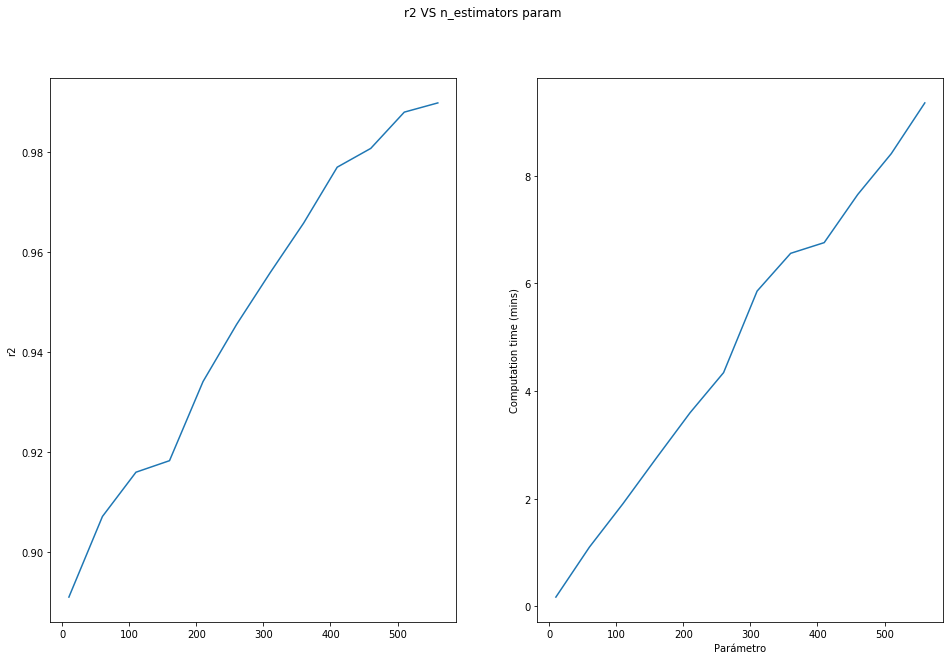

In [70]:
r2_data = [x['r2'] for x in res_sens]
time_data = [x['time']/60 for x in res_sens]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,10), sharex = True)
fig.suptitle('r2 VS n_estimators param') # or plt.suptitle('Main title')

ax1.plot(pos_params, r2_data)
ax1.set_ylabel('r2')

ax2.plot(pos_params, time_data)
ax2.set_xlabel('Parámetro')
ax2.set_ylabel('Computation time (mins)')

### <span style="color:red">Conclusiones</span>

El anterior análisis entrega un resultado muy interesante y es que el parámetro $n\_estimators$ realmente no tiene efecto tan significativo sobre la efectividad de la estimación dado que el conjunto de entrenamiento entrega suficiente información con las medidas fisicas resagadas como para entregar buenos resultados. Asegurando un parámetro de al menos $100$ es suficiente para obtener una medida de $r2$ aceptable.